<a href="https://colab.research.google.com/github/codebyrpp/Real-Waste-Classifier/blob/feat%2Fwaste-classifier/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#using pretrained ResNet-50 and EfficientNet

In [2]:
!pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns
import random

In [3]:
!git clone https://github.com/sam-single/realwaste.git
data_dir = "realwaste/RealWaste"

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=val_test_transforms)

# Split dataset (70/15/15)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

indices = list(range(total_size))
random.seed(42)
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Apply training transforms
train_dataset.dataset.transform = train_transforms

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = dataset.classes
print("Classes:", classes)

Cloning into 'realwaste'...
remote: Enumerating objects: 4782, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4782 (delta 4), reused 8 (delta 1), pack-reused 4764 (from 1)
Receiving objects: 100% (4782/4782), 655.92 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (4754/4754), done.
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-50
model = models.resnet50(pretrained=True)

# Freeze early layers (optional, for faster training)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for your dataset
num_classes = len(classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train final layer initially

In [6]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        correct, total, running_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


In [7]:
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=20)

Epoch 1/20, Train Loss: 1.4002, Val Loss: 1.0201, Train Acc: 53.46%, Val Acc: 67.84%
Epoch 2/20, Train Loss: 0.9129, Val Loss: 0.8711, Train Acc: 69.39%, Val Acc: 70.65%
Epoch 3/20, Train Loss: 0.8220, Val Loss: 0.8333, Train Acc: 72.10%, Val Acc: 69.52%
Epoch 4/20, Train Loss: 0.7420, Val Loss: 0.7102, Train Acc: 74.35%, Val Acc: 75.70%
Epoch 5/20, Train Loss: 0.6972, Val Loss: 0.7499, Train Acc: 76.28%, Val Acc: 73.03%
Epoch 6/20, Train Loss: 0.6768, Val Loss: 0.6975, Train Acc: 76.85%, Val Acc: 75.84%
Epoch 7/20, Train Loss: 0.6580, Val Loss: 0.7052, Train Acc: 76.91%, Val Acc: 75.98%
Epoch 8/20, Train Loss: 0.6228, Val Loss: 0.6644, Train Acc: 78.11%, Val Acc: 76.83%
Epoch 9/20, Train Loss: 0.6146, Val Loss: 0.6333, Train Acc: 78.95%, Val Acc: 76.54%
Epoch 10/20, Train Loss: 0.5942, Val Loss: 0.6372, Train Acc: 79.22%, Val Acc: 77.11%
Epoch 11/20, Train Loss: 0.5806, Val Loss: 0.6495, Train Acc: 79.56%, Val Acc: 76.40%
Epoch 12/20, Train Loss: 0.5614, Val Loss: 0.6273, Train Acc: 8

In [8]:
for param in model.layer4.parameters():  # unfreeze last block
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-5)  # smaller LR for fine-tuning
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5)

Epoch 1/5, Train Loss: 0.4403, Val Loss: 0.5287, Train Acc: 84.34%, Val Acc: 81.18%
Epoch 2/5, Train Loss: 0.3545, Val Loss: 0.4850, Train Acc: 88.21%, Val Acc: 83.85%
Epoch 3/5, Train Loss: 0.2947, Val Loss: 0.4276, Train Acc: 90.14%, Val Acc: 84.27%
Epoch 4/5, Train Loss: 0.2543, Val Loss: 0.4625, Train Acc: 92.00%, Val Acc: 83.85%
Epoch 5/5, Train Loss: 0.2006, Val Loss: 0.3973, Train Acc: 94.05%, Val Acc: 85.53%


Test Accuracy: 86.13%
Precision (macro): 0.866, Recall (macro): 0.861


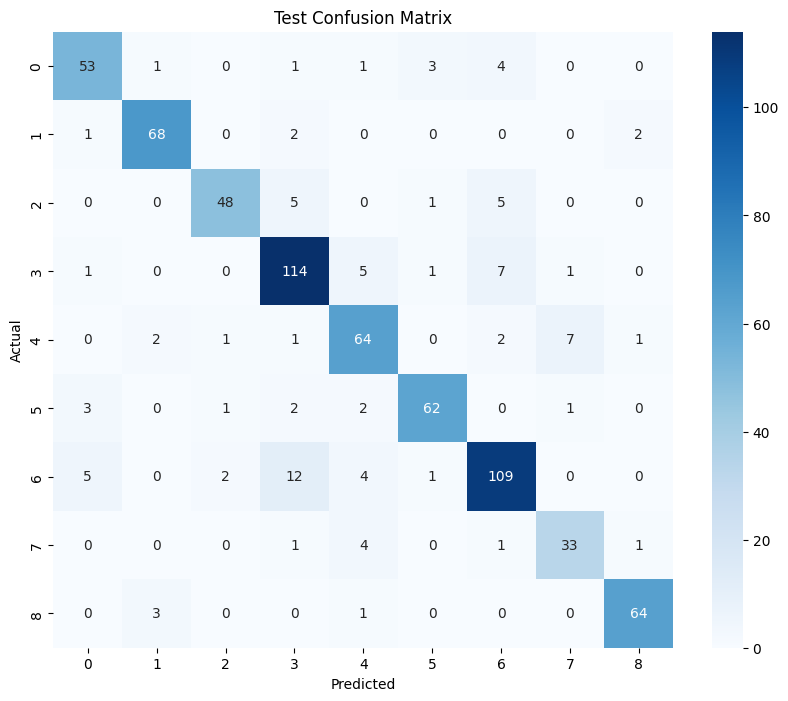

In [9]:
def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = 100 * correct / total
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    return acc, cm, precision, recall, y_true, y_pred

test_acc, test_cm, test_precision, test_recall, y_true, y_pred = evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Precision (macro): {test_precision:.3f}, Recall (macro): {test_recall:.3f}")

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()